# 데이터 수집  
아래 코드는 실행하지 말아주세요 :)

In [ ]:
def insta_searching(word):
    url = "https://www.instagram.com/explore/tags/" + word
    return url

def select_first(driver):
    first = driver.find_element_by_css_selector("div._9AhH0")
    first.click()
    time.sleep(3)

def get_content(driver):

    html = driver.page_source
    soup = BeautifulSoup(html, 'lxml')
    # 본문 내용
    try:
        content = soup.select('div.C4VMK > span')[0].text
    except:
        content = ' '
    # 해시태그
    tags = re.findall(r'#[^\s#,\\]+', content)
    # 작성일자
    date = soup.select('time._1o9PC.Nzb55')[0]['datetime'][:10]
    # 좋아요
    try:
        like = soup.select('div.Nm9Fw > button')[0].text[4:-1]
    except:
        like = 0
    # 위치
    try:
        place = soup.select('div.M30cS')[0].text
    except:
        place = ''

    data = [date, like, place, tags]
    return data

def move_next(driver):

    right = driver.find_element_by_css_selector ('a.coreSpriteRightPaginationArrow')
    right.click()
    time.sleep(5)

def check_result(fname = 'result.csv'):
    dirc = 'C:/Users/jhk32/OneDrive/바탕 화면/Coding/'
    check = os.listdir(dirc)
    if fname in check:
        os.remove(dirc + fname)

if __name__ == "__main__":
    from selenium import webdriver
    from bs4 import BeautifulSoup
    import time
    import re
    import pandas as pd
    import os

    # 이전 결과 덮어쓰기 방지
    check_result('hotplace.csv')

    driver = webdriver.Chrome("C:/chromedriver_win32/win32_chromedriver.exe")
    tag = '강릉가볼만한곳'
    url = insta_searching(tag)
    driver.get(url)
    time.sleep(1.5)
    #로그인
    try:
        elem_login = driver.find_element_by_name("username")
        elem_login.clear()
        elem_login.send_keys('ID')
        elem_login = driver.find_element_by_name('password')
        elem_login.clear()
        elem_login.send_keys('Password')
        time.sleep(1)
        driver.find_element_by_css_selector('#loginForm > div > div:nth-child(3)').click()
        time.sleep(4)
        xpath1 = """//*[@id="react-root"]/section/main/div/div/div/div/button"""
        driver.find_element_by_xpath(xpath1).click()
        time.sleep(4)

        driver.get(url)
        time.sleep(10)

    except:
    # 검색페이지 접속
        driver.get(url)
        time.sleep(10)
    # 첫번째 게시글 열기
    select_first(driver)
    results = []
    #여러 게시물 크롤링하기
    target = 1000 #크롤링할 게시물 수
    for i in range(target):
        data = get_content(driver) #게시물 정보 가져오기
        df = pd.DataFrame(data = data)
        df.to_csv('C:/Users/jhk32/OneDrive/바탕 화면/Coding/hotplace.csv', mode = 'a',
                    header = None, index = False)
        move_next(driver)

    driver.close()


# 0. Import Packages

In [ ]:
# ===================================================================== Setup ===================================================================== 
def Mount_drive():
    from google.colab import drive
    drive.mount('/content/drive')

def Install_Nanumfont():
    #나눔폰트 설치
    %config inlineBackend.figure_format = 'retina'
    !apt -qq -y install fonts-nanum

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
    font = fm.FontProperties(fname = fontpath, size = 9)
    plt.rc('font', family='NanumBarunGothic')
    mpl.font_manager._rebuild()

# ============================================================ Import Modules  ===================================================================== 
try:
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    import requests
    import folium
    print('Import Complete', end = '\n')
except:
    print('Import Error', end = '\n')

# ========================================================= define Subroutines  ===================================================================== 
class Clean:
    def load_data(self, file_name, raw = False):
        #데이터 가져오기, raw option은 raw data를 사용할 경우에 True
        if raw == 0:
            dirc = f'/content/drive/MyDrive/GWNU_datascience/Data/{file_name}'
            df = pd.read_csv(dirc)
        else:
            dirc = f'/content/drive/MyDrive/GWNU_datascience/Data/Raw_data/{file_name}'
            df = pd.read_csv(dirc)
            df.loc[-1] = [df.columns[0]]
            df.index = df.index + 1
            df = df.sort_index()
        return df

    def reshape_dataframe(self, data, col_num = 4):
        # 데이터를 각 column 개수에 맞게 변환해주는 함수
        assert data.shape == (4000, 1) #shape은 항상 (4000, 1)이어야 함.

        shp_0 = data.shape[0]

        result = data.to_numpy().reshape(int(shp_0 / col_num), col_num)
        return pd.DataFrame(result)

    def filter(self, list_, word_to_filter):
        #태그에 불용어들을 제거하는 함수
        new = []
        for i in list_:
            if i not in word_to_filter:
                new.append(i)
        return new

class Wrangling:
    file_name_ = ['hotplace.csv', 'travle.csv', 'wheretogo.csv']
    def __init__(self):
        self.root = pd.DataFrame()
        self.data = pd.DataFrame()
        self.box = pd.DataFrame()
        self.files = {}
    

    def Save_Data(self):
        #데이터를 저장하는 함수
        for f in Wrangling.file_name_:
            print(f)
            clean = Clean() #위에서 지정한 Clean class - load_data와 reshape을 사용하기 위함
            self.root = clean.load_data(f, True) #데이터를 불러오는 함수, raw 옵션은 raw_data를 가져오는 옵션
            self.data = clean.reshape_dataframe(self, self.root) 
            self.data.columns = ['date', 'drop', 'place', 'tags'] #사용할 column의 
            self.data = self.data.drop('drop', axis = 1)

            #==============================저장완료==============================#
            #print(data.head())
            #data.to_csv(save_dir, index = False)
            #print(f"{f} | finished!")
        
    def Preprocessing(self):
        # 해시태그 제거 및 데이터 병합
        # 해시태그 제거
        hashtag = '#'
        for f in Wrangling.file_name_:
            clean = Clean()
            self.root = clean.load_data(f, False)
            self.root.tags = self.root.tags.str.replace(hashtag, '')
            self.files[f.rstrip('.csv')] = self.root
        # 3가지 데이터 병합 
        for f in Wrangling.file_name_:
            self.box = pd.concat([self.box, self.files[f.rstrip('.csv')]]).reset_index(drop = True)

        #print(f"before concat) {files['hotplace'].shape} x {len(files.keys())} \nafter  concat) {box.shape}")

class Filtering:
    def Plot_WordCloud(self, data, figsize = (15, 8)):
        # 워드클라우드를 그리는 함수, input으로 데이터를 받음
        mask = np.array(Image.open('/content/drive/MyDrive/GWNU_datascience/Data/gangneung.png'))
        wc = WordCloud(font_path = fontpath, background_color = 'white',
                    width = 800, height = 600, mask = mask)
        cloud = wc.generate_from_frequencies(dict(data))
        plt.figure(figsize = figsize)
        plt.axis('off')
        plt.imshow(cloud);

    def Make_DF_namecount(self, data):
        # [태그이름 | 개수] 데이터프레임을 만드는 함수
        # 데이터는 collection 데이터로 들어오기 때문에 따로 만들어줌
        tags_df = {}
        val = data.values()
        key = data.keys()
        tags_df['name'] = [i for i in key]
        tags_df['count'] = [i for i in val]
        return pd.DataFrame(tags_df)

    def Filter_Words(self, data, word_to_filter):
        #태그들을 필터링하는 함수
        for i in word_to_filter:
            data = data.loc[data.name != i] #태그들 제거
        data = data.sort_values(by = 'count', ascending = False)
        data = data.reset_index(drop = True)
        return data

def GetInfo(keyword):
    # 카카오맵 api에서 키워드의 카테고리, 위도, 경도를 가져오는 함수
    url = f'https://dapi.kakao.com/v2/local/search/keyword.json?query={keyword}'
    api_key = '281833811ed588a552349b18ce7aa806'

    header = {'Authorization': f'KakaoAK {api_key}'}
    r = requests.get(url, headers=header).json()
    try:
        info = r['documents'][0]
        lat, lon = info["y"], info["x"]
        category = info['category_group_name']
        return [category, float(lat), float(lon)]
    except:
        #오류나면 다음을 반환
        return ['No Result', 0, 0]

class Folium_setup:
    #Folium Map에 쓸 color 정보와 icon 정보를 생성하는 함수 
    #수정 후 (카페/음식점/관광명소)
    #color(카페/식당/명소)
    def color_(self, data):
        global color #전역변수 설정
        if data.loc[i,'type'] == '카페':
            color = 'blue'
        elif data.loc[i,'type'] == '음식점':
            color = "orange"
        elif data.loc[i,'type'] == '관광명소':
            color = 'green'
        return color

    #icon(type)
    def icon_(self, data):
        global icon #전역변수 설정
        if data.loc[i,'type'] == '카페':
            icon = 'glass'
        elif data.loc[i,'type'] == '음식점':
            icon = 'cutlery'
        elif data.loc[i,'type'] == '관광명소':
            icon = 'star'
        return icon
    
    def legacy(self, data): 
        global color, icon
        if data.loc[i,'type'] == '카페':
            color = 'blue'
            icon = 'glass'
        elif data.loc[i,'type'] == '식당':
            color = "orange"
            icon = 'cutlery'
        elif data.loc[i,'type'] == '명소':
            color = 'green'
            icon = 'star'
        return [color, icon]

Import Complete


In [ ]:
Mount_drive()
Install_Nanumfont()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


제발 런타임 재시작..!!

In [ ]:
wrang = Wrangling()
#yongmin.Save_Data() -> 저장이 완료된 상태이므로 주석처리
wrang.Preprocessing()

In [ ]:
Clean().load_data(file_name = 'hotplace.csv', raw = True)

,2021-03-23
0,2021-03-23
1,0
2,동해막국수 강문점
3,"['#메밀김밥', '#메밀김밥_레드매장에서', '#메밀김밥_옐로우큼직큼직한']"
4,2021-02-28
...,...
3995,[]
3996,2021-03-29
3997,0
3998,강문해변


In [ ]:
wrang.root

,date,location,tags
0,2021-04-08,강릉,"['당신의안목]⠀📍', '강릉', '당신의안목📍120', '여행머무름', '여름_강..."
1,2021-03-30,NaN,"['강릉예쁜카페', '강릉카페추천', '강릉카페투어', '강릉가볼만한곳', '주문진..."
2,2021-04-01,쌍둥이동물농장,"['광고', '강릉', '주말_나들이!다양한', '강릉쌍둥이동물동물농장', '강릉동..."
3,2021-04-10,NaN,"['강릉맛집', '강릉맛집추천', '강릉고기집', '강릉가볼만한곳', '강릉여행',..."
4,2021-03-31,Gangneung,[]
...,...,...,...
995,2021-04-09,NaN,[]
996,2021-04-09,Gangneung,[]
997,2021-04-07,핫플,"['강릉', '강릉카페', '강릉맛집', '강릉여행', '몽슈슈캔들']"
998,2021-04-07,핫플,"['강릉', '강릉카페', '강릉카페추천', 'ᄀ..."


<font size =4> 가져온 데이터를 Pandas DataFrame으로 정리

In [ ]:
bbox = wrang.box
bbox

,date,location,tags
0,2021-03-23,동해막국수 강문점,"['메밀김밥', '메밀김밥_레드매장에서', '메밀김밥_옐로우큼직큼직한']"
1,2021-02-28,새바람이오는그늘,"['강릉시내', '강릉가볼만한곳', '강릉여행', '강릉여행지', '강릉여행지추천'..."
2,2021-04-06,NaN,"['강릉맛집', '강릉맛집추천', '강릉고기집', '강릉가볼만한곳', '강릉여행',..."
3,2021-03-14,NaN,"['강릉맛집', '강릉맛집추천', '강릉고기집', '강릉가볼만한곳', '강릉여행',..."
4,2021-03-16,새바람이오는그늘,"['강릉가볼만한곳', '강릉여행', '강릉여행지', '강릉여행지추천', '강릉여행코..."
...,...,...,...
2995,2021-04-09,NaN,[]
2996,2021-04-09,Gangneung,[]
2997,2021-04-07,핫플,"['강릉', '강릉카페', '강릉맛집', '강릉여행', '몽슈슈캔들']"
2998,2021-04-07,핫플,"['강릉', '강릉카페', '강릉카페추천', 'ᄀ..."


어떤 곳에서 사람들이 태그를 많이 올렸을까?

In [ ]:
bbox.location.value_counts() #어떤 지역들이 많은지 확인하기 위함

Gangneung             146
주주파크                  119
강릉                     69
강릉 고양이카페 '쓰담쓰담'        23
강문해변                   20
                     ... 
강원도                     1
금천칼국수                   1
Singlefin aleworks      1
강일여고                    1
Travel cafe & Pub       1
Name: location, Length: 254, dtype: int64

* 주주파크 키워드가 다른 가게이름이나 지역명 키워드들에 비해 압도적으로 많음 -> 광고성으로 여러번 반복적으로 올렸다  
(제거대상!!) 

In [ ]:
import random
i = bbox[bbox.location == '주주파크'].index
for x in range(5):
    print(bbox[bbox.location == '주주파크'].loc[random.choice(i), 'tags'])
#랜덤으로 주주파크 태그가 있는 게시물에서 5개 뽑아보기

['대관령주주파크', '주주파크', '대관령여행', '대관령', '대관령동물농장', '대관령체험', '대관령아이들과가볼만한곳', '평창맘', '평창가볼만한곳', '평창동물체험', '평창여행', '강릉핫플레이스', '강릉맘', '강릉여행', '강릉', '평창아이들과가볼만한곳', '삼양목장', '하늘목장', '양떼목장', '평창앵무새', '앵무새체험', '용평리조트', '평창핫플레이스', '휘닉스파크', '알파카', '평창알파카목장', '평창승마체험', '평창갈만한곳', '토끼농장', '평창동물농장']
['대관령주주파크', '주주파크', '대관령여행', '대관령', '대관령동물농장', '대관령체험', '대관령아이들과가볼만한곳', '평창맘', '평창가볼만한곳', '평창동물체험', '평창여행', '강릉핫플레이스', '강릉맘', '강릉여행', '강릉', '평창아이들과가볼만한곳', '삼양목장', '하늘목장', '양떼목장', '평창앵무새', '앵무새체험', '용평리조트', '평창핫플레이스', '휘닉스파크', '알파카', '평창알파카목장', '평창승마체험', '평창갈만한곳', '원주맘', '평창동물농장']
['대관령주주파크', '주주파크', '대관령여행', '대관령', '대관령동물농장', '대관령체험', '대관령아이들과가볼만한곳', '평창맘', '평창가볼만한곳', '평창동물체험', '평창여행', '강릉핫플레이스', '강릉맘', '강릉여행', '강릉', '평창아이들과가볼만한곳', '삼양목장', '하늘목장', '양떼목장', '평창앵무새', '앵무새체험', '용평리조트', '평창핫플레이스', '휘닉스파크', '알파카', '평창알파카목장', '평창승마체험', '평창갈만한곳', '토끼농장', '평창동물농장']
['대관령주주파크', '주주파크', '대관령여행', '대관령', '대관령동물농장', '대관령체험', '대관령아이들과가볼만한곳', '평창맘', '평창가볼만한곳', '평창동물체험', '평창여행', '강릉핫플레이스', '강릉맘', '강릉여행', '강릉', '평창아이들과가볼만한곳', 

In [ ]:
bbox = bbox[bbox.location != '주주파크'] #boolean indexing으로 각 키워드들이 포함된 row를 제거

In [ ]:
bbox.location.value_counts()

Gangneung             146
강릉                     69
강릉 고양이카페 '쓰담쓰담'        23
강문해변                   20
강릉 안목해변 커피거리           17
                     ... 
강원도                     1
금천칼국수                   1
Singlefin aleworks      1
강일여고                    1
Travel cafe & Pub       1
Name: location, Length: 253, dtype: int64

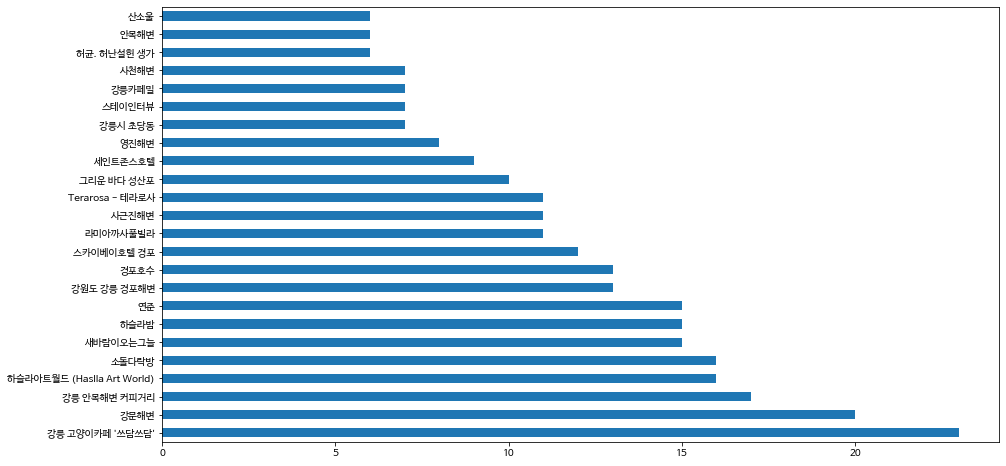

In [ ]:
plt.figure(figsize = (15, 8))
bbox.location.value_counts()[2:26].plot.barh();

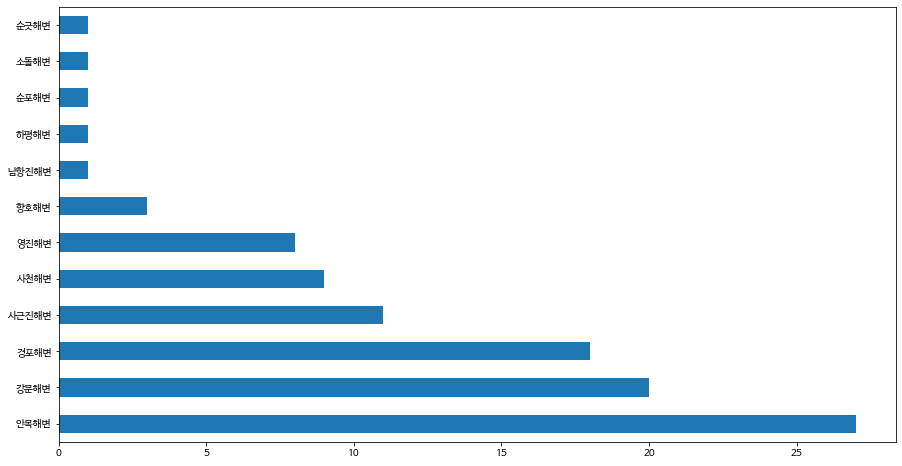

In [ ]:
bbox_ = bbox.dropna().reset_index(drop = True)
beach = ['강문', '경포', '안목', '사근진', '영진', '사천', '향호', '순긋', '소돌', '순포', '하평', '남항진']
beaches = {}
for i in beach:
    beaches[f'{i}해변'] = bbox_.loc[bbox_.location.str.contains("해변"), 'location'].str.count(i).sum()
beaches = pd.Series(beaches).sort_values(ascending = False)
plt.figure(figsize = (15, 8))
beaches.plot.barh();

* 데이터상으로는 안목해변, 강문해변, 경포해변(경포호), 사근진해변, 사천해변 순으로 사람들이 많이 방문하는것 같음  
> 안목은 카페거리가 유명해서 놀러오는 것 같음

### b) Data type transformation

* 태그로 분석을 하려는 이유
> 인스타그램 게시물에서 보통 같은 태그를 여러번 쓰지는 않기때문에 태그 하나당 게시물 하나정도의 대표성이 있기도 하고 location은 잘 남기지 않더라도 tag는 잘 남기는 사람들이 더 많기 때문

<font size = 4>  
* 데이터를 처리하려는 중 문제가 발생함..  
    (데이터가 "['tag1', 'tag2', 'tag3', ...]"처럼 string 형태로 들어가있었음)  
* 따라서 string으로 된 list를 일반 list로 돌려놓아야 이후 처리가 가능함.
</font>

In [ ]:
import ast #string으로 되어있는 "[1,2,3,4]"를 [1,2,3,4]로 전환해주는 모듈

In [ ]:
bbox.tags[0]

"['메밀김밥', '메밀김밥_레드매장에서', '메밀김밥_옐로우큼직큼직한']"

In [ ]:
ast.literal_eval(bbox.tags[0])

['메밀김밥', '메밀김밥_레드매장에서', '메밀김밥_옐로우큼직큼직한']

In [ ]:
tags = []
i = 0
for word in bbox.tags:
    word = ast.literal_eval(word) #리스트로 변환
    tags += word #워드클라우드로 사용할 수 있게 한 리스트로 합침

In [ ]:
from collections import Counter #counting element를 쉽게 하기 위한 특수한 Python Container -> 확장된 Dictionary의 일종
count = Counter(tags) 
count = count.most_common() #가장 많은순으로 정렬

> 1. 크롤링한 인스타그램 태그에서 "관광지"보다 "맛집"을 찾는 사람들이 많다.  
2. 그리고 강릉에 와서 카페를 많이 간다. 

In [ ]:
count[:50] #상위 50개만 하더라도 실제 가게 이름들은 10개도 없음.

[('강릉여행', 1994),
 ('강릉맛집', 1539),
 ('강릉가볼만한곳', 1524),
 ('강릉핫플', 1185),
 ('강릉여행코스', 1042),
 ('강릉핫플레이스', 972),
 ('강원도여행', 862),
 ('강릉데이트코스', 788),
 ('강릉데이트', 745),
 ('강릉맛집추천', 714),
 ('경포대맛집', 625),
 ('강릉여행중', 618),
 ('강릉역맛집', 615),
 ('강릉카페', 570),
 ('강릉', 509),
 ('강릉현지인맛집', 470),
 ('강문해변맛집', 431),
 ('강릉시내맛집', 380),
 ('강릉커피', 358),
 ('강릉고기맛집', 346),
 ('강릉커피거리', 324),
 ('강릉카페거리', 322),
 ('강문해변카페', 303),
 ('경포대카페', 299),
 ('강릉카페346커피스토리', 298),
 ('강릉술집', 297),
 ('강릉교동맛집', 253),
 ('교동택지맛집', 248),
 ('강릉맛집원가정', 223),
 ('강릉횟집', 218),
 ('강릉맛집삼십미리', 217),
 ('강릉데이트코', 217),
 ('강문해변', 215),
 ('안목해변맛집', 167),
 ('강릉맘', 153),
 ('삼십미리..', 137),
 ('346커피스토리..', 126),
 ('강릉맛집베스트', 122),
 ('강릉삼겹살', 114),
 ('강릉펜션', 113),
 ('원가정...', 112),
 ('원가정..강원', 111),
 ('경포대횟집', 109),
 ('맛집스타그램', 108),
 ('경포해변맛집', 105),
 ('교동맛집', 103),
 ('since1994', 101),
 ('정선이모네식당', 101),
 ('강릉맛집_정선이모네식당', 101),
 ('강릉장칼국수', 101)]

### c) Word Cloud

어떤 태그가 많은지 편하게 확인하기 위함

In [ ]:
!pip install wordCloud #워드클라우드 설치
from PIL import Image

import matplotlib.pyplot as plt
from wordcloud import WordCloud
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

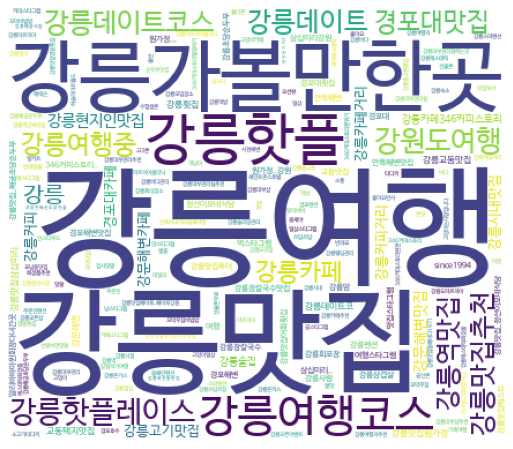

In [ ]:
Filtering().Plot_WordCloud(count)

<font size =4>  
* 워드클라우드로 볼 때 검색키워드로 사용했던 단어들이 가장 많은 것을 알 수 있음.  
본격적인 단어 필터링 시작  
</font>


### d) Word Filtering

In [ ]:
word_to_filter = [count[i][0] for i in range(len(count))][:20] #상위 20개만 제거
filtered_1 = Clean().filter(tags, word_to_filter)
count = Counter(filtered_1)

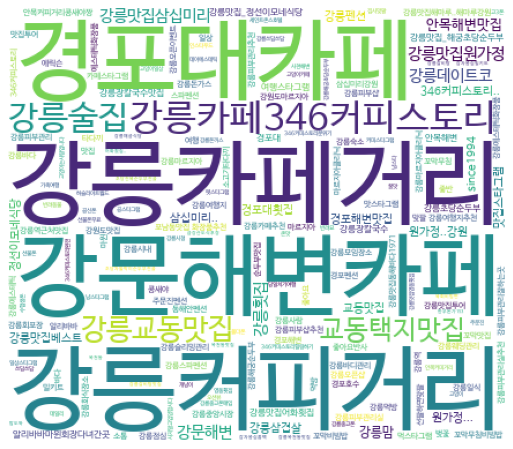

In [ ]:
Filtering().Plot_WordCloud(count)

* 상위 20개가 제거된 태그들에서는 강릉에 놀러온 사람들이 바닷가에 있는 카페거리를 많이가는 것으로 확인됨.  
* 여전히 필터링해야할 단어들이 보임, 중간에 가게이름이 유독 많이 count 된 것이 보임 -> 인스타그램 이벤트를 하나??

In [ ]:
Counter(filtered_1).most_common(50)

[('강릉커피거리', 324),
 ('강릉카페거리', 322),
 ('강문해변카페', 303),
 ('경포대카페', 299),
 ('강릉카페346커피스토리', 298),
 ('강릉술집', 297),
 ('강릉교동맛집', 253),
 ('교동택지맛집', 248),
 ('강릉맛집원가정', 223),
 ('강릉횟집', 218),
 ('강릉맛집삼십미리', 217),
 ('강릉데이트코', 217),
 ('강문해변', 215),
 ('안목해변맛집', 167),
 ('강릉맘', 153),
 ('삼십미리..', 137),
 ('346커피스토리..', 126),
 ('강릉맛집베스트', 122),
 ('강릉삼겹살', 114),
 ('강릉펜션', 113),
 ('원가정...', 112),
 ('원가정..강원', 111),
 ('경포대횟집', 109),
 ('맛집스타그램', 108),
 ('경포해변맛집', 105),
 ('교동맛집', 103),
 ('since1994', 101),
 ('정선이모네식당', 101),
 ('강릉맛집_정선이모네식당', 101),
 ('강릉장칼국수', 101),
 ('강릉장칼국수맛집', 101),
 ('강릉맛집_해궁초당순두부', 96),
 ('강릉초당순두부', 96),
 ('알리바바마윈회장다녀간곳', 96),
 ('강릉맛집어화횟집', 94),
 ('안목해변', 88),
 ('경포대', 80),
 ('여행스타그램', 79),
 ('강릉맛집투어', 69),
 ('강릉사람', 69),
 ('강릉회포장', 67),
 ('강릉여행', 66),
 ('삼십미리강원', 64),
 ('여행', 62),
 ('먹스타그램', 60),
 ('경포해변', 60),
 ('강릉맛집해마루..해마루강원', 60),
 ('일상', 59),
 ('꼬막무침비빔밥', 57),
 ('강릉맛집', 55)]

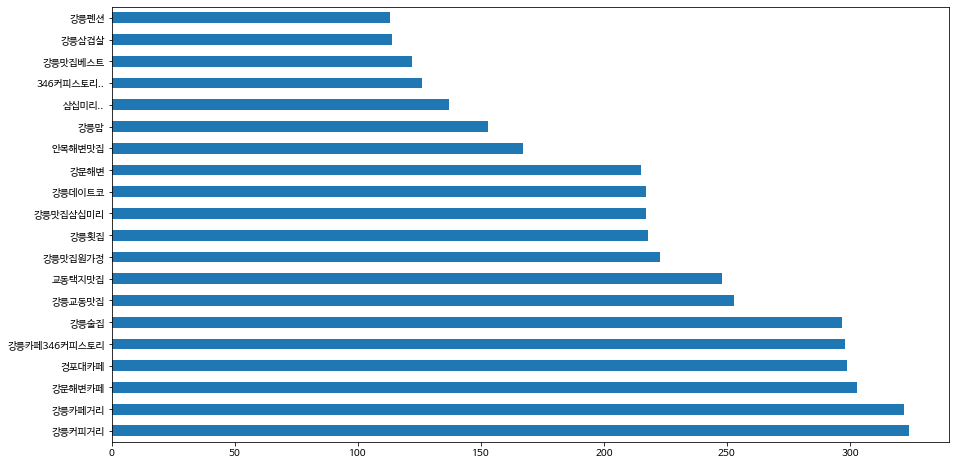

In [ ]:
plt.figure(figsize = (15, 8))
pd.Series(filtered_1).value_counts()[:20].plot.barh(); #개수가 너무 많으면 폰트에러남;;

In [ ]:
s = pd.Series(filtered_1)
s.loc[s.str.contains("커피스토리")]

244        346커피스토리완전
245      강릉카페346커피스토리
294        346커피스토리..
295      강릉카페346커피스토리
303      강릉카페346커피스토리
             ...     
21034    강릉카페346커피스토리
21243      346커피스토리..
21244    강릉카페346커피스토리
21457      346커피스토리완전
21458    강릉카페346커피스토리
Length: 530, dtype: object

In [ ]:
word_to_filter = ['강릉술집', '강릉교동맛집', '교동택지맛집', '강릉횟집', '강릉데이트코',
                  '강릉맘', '강릉맛집베스트', '강릉펜션', '원가정...', '원가정..강원',
                  '삼십미리..', '안목해변맛집', '346커피스토리..', '강릉삼겹살', '맛집스타그램',
                  '경포해변맛집', '교동맛집', '강릉맛집_정선이모네식당', '강릉장칼국수맛집', '알리바바마윈회장다녀간곳',
                  '강릉초당순두부', '여행스타그램', '강릉사람', '강릉맛집투어', '강릉회포장',
                  '강릉여행', '삼십미리강원', '여행', '먹스타그램', '일상', '꼬막무침비빔밥',
                  '강릉맛집', '강릉숙소', '꼬막비빔밥', '먹방', '맛집투어',
                  '포탐동맛집', '좋아요', '맛스타그램', '콩새야', '강릉여행',
                  '강릉맛집', '강릉카페거리', '강릉여행', '포남동맛집']

In [ ]:
f = Filtering()
AA = f.Make_DF_namecount(count)
AA = f.Filter_Words(AA, word_to_filter)
AA

,name,count
0,강릉커피거리,324
1,강문해변카페,303
2,경포대카페,299
3,강릉카페346커피스토리,298
4,강릉맛집원가정,223
...,...,...
4680,외출,1
4681,dailygram,1
4682,instafood,1
4683,맛스타그램,1


In [ ]:
filn = '/content/drive/MyDrive/GWNU_datascience/Data/hashtag_count.pkl'
AA.to_pickle(path = filn)

* Python Pickle이라는 파일 형식으로 저장하여 csv보다 빠르고 쉽게 불러올 수 있도록 함

## e) Data Visualization with folium 

* tag, location으로 확인했을 때 수가 많았던 장소들의 위치를 지도에 표출

### Hashtag로 만든 지도

In [ ]:
Hashtag = pd.read_pickle(filn)
Hashtag

,name,count
0,강릉커피거리,324
1,강문해변카페,303
2,경포대카페,299
3,강릉카페346커피스토리,298
4,강릉맛집원가정,223
...,...,...
4680,외출,1
4681,dailygram,1
4682,instafood,1
4683,맛스타그램,1


In [ ]:
Hashtag = Hashtag.sort_values(by = 'count', ascending = False)[:20]

rename_ind = [3, 4, 5, 11, 12 ,15, 18]
rename_str = '346커피스토리 원가정 30mm 해궁초당순두부 어화횟집 해마루 콩새야'.split() #데이터 이름을 맞춰주는 과정

for i in range(len(rename_ind)):
    Hashtag.loc[rename_ind[i], 'name'] = rename_str[i]

Hashtag = Hashtag.drop([9, 10, 19]) #일부 단어 제거
Hashtag = Hashtag.reset_index(drop = True)

In [ ]:
Hashtag['type'], Hashtag['위도'], Hashtag['경도'] = "", "", "" #초기화

for i in range(len(Hashtag)):
    Hashtag['type'][i], Hashtag['위도'][i], Hashtag['경도'][i] = GetInfo(Hashtag['name'][i]) #위경도, type을 가져옴

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
Hashtag

,name,count,type,위도,경도
0,강릉커피거리,324,관광명소,37.7727,128.947
1,강문해변카페,303,카페,37.7947,128.919
2,경포대카페,299,카페,37.7879,128.908
3,346커피스토리,298,카페,37.7945,128.919
4,원가정,223,음식점,37.7648,128.88
5,30mm,217,음식점,37.7666,128.879
6,강문해변,215,관광명소,37.7948,128.919
7,경포대횟집,109,음식점,37.7995,128.914
8,강릉장칼국수,101,음식점,37.7575,128.893
9,해궁초당순두부,96,음식점,37.7955,128.914


In [ ]:
Hashtag['type'].loc[Hashtag['type'] == ''] = '관광명소' #검색결과가 여러곳이거나 카테고리가 분류되지 않은 곳은 빈칸으로 나타났음

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
Hashtag

,name,count,type,위도,경도
0,강릉커피거리,324,관광명소,37.7727,128.947
1,강문해변카페,303,카페,37.7947,128.919
2,경포대카페,299,카페,37.7879,128.908
3,346커피스토리,298,카페,37.7945,128.919
4,원가정,223,음식점,37.7648,128.88
5,30mm,217,음식점,37.7666,128.879
6,강문해변,215,관광명소,37.7948,128.919
7,경포대횟집,109,음식점,37.7995,128.914
8,강릉장칼국수,101,음식점,37.7575,128.893
9,해궁초당순두부,96,음식점,37.7955,128.914


In [ ]:
long_ = Hashtag['경도'].mean()
lat = Hashtag['위도'].mean()

MAP = folium.Map([lat,long_],zoom_start=13)
for i in Hashtag.index:
    
    fo = Folium_setup()
    sub_lat =  Hashtag.loc[i,'위도']
    sub_long = Hashtag.loc[i,'경도']
    title = Hashtag.loc[i, 'name']
    
    #지도에 표시
    folium.Marker([sub_lat,sub_long], tooltip = title, icon=folium.Icon(color=fo.color_(Hashtag), icon=fo.icon_(Hashtag))).add_to(MAP)
MAP

### location으로 만든 지도

In [ ]:
Gangneung = {'위도' : [37.79450135674353, 37.764850662672906, 37.76661922543233, 37.7966796728289, 37.75996614891032, 37.795836948686954, 37.79465497532444, 37.773164402029984, 37.80550502626482, 37.76424586770988, 37.83000502846524, 37.79470023761486, 37.869262643105785, 37.81248123914733, 37.69618391169444, 37.79808877606378, 37.74973395345872, 37.77015839873503, 37.75665277086456, 37.7068976779097, 37.904593674251004, 37.77265784055902, 37.754221332289866],
             '경도' : [128.9190243508946, 128.8801475276303, 128.87864041759948, 128.91754746431675, 128.89484394004617, 128.91361882655252, 128.91876356888207, 128.94726590056783, 128.90782477482514, 128.95378457213317, 128.87851333161632, 128.91750790830216, 128.84522706332342, 128.8993545713046, 128.89189685260808, 128.90855816610437, 128.89041615416076, 128.90994074094905, 128.86935538279116, 129.01098569788846, 128.82248508623698, 128.94720329789007, 128.89413349788956],
             'place' : ['346커피스토리', '원가정', '30mm', '강문해변', '정선이모네식당', '해궁초당순두부', '강문어화횟집', '안목해변', '경포해변', '해마루','사천해변','카페밀','영진해변','사근진해변','테라로사','경포호수','새바람이 오는 그늘','연준','하슬라밤','하슬라아트월드','소돌다락방','카페거리','쓰담쓰담'],
             'type' : ['카페', '식당', '식당', '명소', '식당', '식당', '식당', '명소', '명소', '식당','명소','카페','명소','명소','카페','명소','카페','식당','식당','명소','카페','명소','카페'],
             'count' : ['330','224','297','219','202','175','101','109','140','67','31','11','17','12','24','34','18','21','-','27','16','646','46']}
Gangneung = pd.DataFrame(Gangneung)
Gangneung

,위도,경도,place,type,count
0,37.794501,128.919024,346커피스토리,카페,330
1,37.764851,128.880148,원가정,식당,224
2,37.766619,128.878640,30mm,식당,297
3,37.796680,128.917547,강문해변,명소,219
4,37.759966,128.894844,정선이모네식당,식당,202
5,37.795837,128.913619,해궁초당순두부,식당,175
6,37.794655,128.918764,강문어화횟집,식당,101
7,37.773164,128.947266,안목해변,명소,109
8,37.805505,128.907825,경포해변,명소,140
9,37.764246,128.953785,해마루,식당,67


In [ ]:
df = Gangneung.sort_values(by='count')
print(df)

           위도          경도       place type count
18  37.756653  128.869355        하슬라밤   식당     -
6   37.794655  128.918764      강문어화횟집   식당   101
7   37.773164  128.947266        안목해변   명소   109
11  37.794700  128.917508         카페밀   카페    11
13  37.812481  128.899355       사근진해변   명소    12
8   37.805505  128.907825        경포해변   명소   140
20  37.904594  128.822485       소돌다락방   카페    16
12  37.869263  128.845227        영진해변   명소    17
5   37.795837  128.913619     해궁초당순두부   식당   175
16  37.749734  128.890416  새바람이 오는 그늘   카페    18
4   37.759966  128.894844     정선이모네식당   식당   202
17  37.770158  128.909941          연준   식당    21
3   37.796680  128.917547        강문해변   명소   219
1   37.764851  128.880148         원가정   식당   224
14  37.696184  128.891897        테라로사   카페    24
19  37.706898  129.010986     하슬라아트월드   명소    27
2   37.766619  128.878640        30mm   식당   297
10  37.830005  128.878513        사천해변   명소    31
0   37.794501  128.919024    346커피스토리   카페   330
15  37.798089  128.9

In [ ]:
long_ = Gangneung['경도'].mean()
lat = Gangneung['위도'].mean()

MAP = folium.Map([lat,long_],zoom_start=13)
for i in Gangneung.index:

    fo = Folium_setup()
    sub_lat =  Gangneung.loc[i,'위도']
    sub_long = Gangneung.loc[i,'경도']
    title = Gangneung.loc[i, 'place']
    
    #지도에 표시
    folium.Marker([sub_lat,sub_long], tooltip = title, icon=folium.Icon(color=fo.legacy(Gangneung)[0], icon=fo.legacy(Gangneung)[1])).add_to(MAP)
MAP

### 공공데이터포털의 강릉시 핫플레이스 데이터로 만든 지도

In [ ]:
filn = '/content/drive/MyDrive/GWNU_datascience/Data/강원도 강릉시_핫플레이스_20210201.csv'
HOTPLACE = pd.read_csv(filn, encoding='cp949')
HOTPLACE

,플레이스명칭,소재지,전화번호,설명,연관 키워드,데이터기준일자
0,안반데기,강원도 강릉시 왕산면 안반덕길 428,NaN,전국 최대 규모의 고랭지 채소단지로 지대가 높아 도시에서는 볼 수 없는 시원한 풍경...,별 관람 명소,2021-02-01
1,주문진 방파제,강원도 강릉시 주문진읍 교항리 81-151,NaN,드라마 도깨비에서 공유가 김고은에게 우산을 씌워주고 메밀꽃을 내미는 명장면을 연출한 장소,도깨비 촬영지,2021-02-01
2,주문진 도깨비시장,강원도 강릉시 주문진읍 학교담길 32-8,033-662-6887,드라마 도깨비 주문진 촬영지 약 100미터 이내 거리에 위치하고 있습니다.,담소당+소쿠리,2021-02-01
3,오죽헌,강원도 강릉시 율곡로3139번길 24,033-660-3301,신사임당과 율곡 이이의 생가이자 검은 대나무 오죽을 볼 수 있는 곳,모자 화폐,2021-02-01
4,오션뷰 카페 곳;,강원도 강릉시 사천면 진리해변길 143,033-646-4500,천국의 계단 포토존으로 유명한 사천진해수욕장 루프탑 오션뷰 카페 곳,천국의 계단,2021-02-01
5,하슬라가배,"강원도 강릉시 창해로14번길 12, 2층",033-652-6662,안목해변 루프탑 카페,안목해변,2021-02-01
6,카페 툇마루,강원도 강릉시 난설헌로 232,033-922-7175,"강릉에서 제일 유명한 흑임자 라떼, 확장 이전",흑임자라떼,2021-02-01
7,명주배롱,강원도 강릉시 경강로2046번길 10,0507-1342-2304,명주동 골목 속 주택을 리모델링한 커피숍,시나미길,2021-02-01
8,경포생태저류지,강원도 강릉시 죽헌동 745,NaN,하천범람을 막기 위해 만들어진 저류지로 2013년 8월에 준공되었다. 경포천의 하천...,메타세콰이어길,2021-02-01
9,명주시나미길,강원도 강릉시 경강로2046번길,NaN,현재와 과거가 뒤섞인 묘한 공간감을 연출,햇살박물관,2021-02-01


In [ ]:
del HOTPLACE['데이터기준일자'] #필요없는 column 제거
del HOTPLACE["전화번호"]
HOTPLACE

,플레이스명칭,소재지,설명,연관 키워드
0,안반데기,강원도 강릉시 왕산면 안반덕길 428,전국 최대 규모의 고랭지 채소단지로 지대가 높아 도시에서는 볼 수 없는 시원한 풍경...,별 관람 명소
1,주문진 방파제,강원도 강릉시 주문진읍 교항리 81-151,드라마 도깨비에서 공유가 김고은에게 우산을 씌워주고 메밀꽃을 내미는 명장면을 연출한 장소,도깨비 촬영지
2,주문진 도깨비시장,강원도 강릉시 주문진읍 학교담길 32-8,드라마 도깨비 주문진 촬영지 약 100미터 이내 거리에 위치하고 있습니다.,담소당+소쿠리
3,오죽헌,강원도 강릉시 율곡로3139번길 24,신사임당과 율곡 이이의 생가이자 검은 대나무 오죽을 볼 수 있는 곳,모자 화폐
4,오션뷰 카페 곳;,강원도 강릉시 사천면 진리해변길 143,천국의 계단 포토존으로 유명한 사천진해수욕장 루프탑 오션뷰 카페 곳,천국의 계단
5,하슬라가배,"강원도 강릉시 창해로14번길 12, 2층",안목해변 루프탑 카페,안목해변
6,카페 툇마루,강원도 강릉시 난설헌로 232,"강릉에서 제일 유명한 흑임자 라떼, 확장 이전",흑임자라떼
7,명주배롱,강원도 강릉시 경강로2046번길 10,명주동 골목 속 주택을 리모델링한 커피숍,시나미길
8,경포생태저류지,강원도 강릉시 죽헌동 745,하천범람을 막기 위해 만들어진 저류지로 2013년 8월에 준공되었다. 경포천의 하천...,메타세콰이어길
9,명주시나미길,강원도 강릉시 경강로2046번길,현재와 과거가 뒤섞인 묘한 공간감을 연출,햇살박물관


In [ ]:
HOTPLACE['latitude']= 37.62260348650471, 37.88286058337085, 37.88162510935754, 37.77943807427878, 37.843393104653394, 37.77331205111516, 37.79287784516604, 37.750916010548835, 37.781305510551476, 37.75085929829436, 37.75408564893004, 37.869883746897955, 37.68383287053492, 37.91220339616345, 37.772612799757944,
HOTPLACE['longitude']= 128.7396394825442, 128.82952024521236, 128.83156039789293, 128.87810566462426, 128.87294560975718, 128.94649394021917, 128.91469362672612, 128.89285946905412, 128.8851888267258, 128.8929940890364, 128.89971732672498, 128.84542117488513, 129.04201149788767, 128.81731642672938,128.9472917929633
HOTPLACE['type']= "명소", "명소", "명소", "명소", "카페", "카페", '카페', "카페", "명소", "명소", "명소","명소", "명소","명소", "명소"
HOTPLACE

,플레이스명칭,소재지,설명,연관 키워드,latitude,longitude,type
0,안반데기,강원도 강릉시 왕산면 안반덕길 428,전국 최대 규모의 고랭지 채소단지로 지대가 높아 도시에서는 볼 수 없는 시원한 풍경...,별 관람 명소,37.622603,128.739639,명소
1,주문진 방파제,강원도 강릉시 주문진읍 교항리 81-151,드라마 도깨비에서 공유가 김고은에게 우산을 씌워주고 메밀꽃을 내미는 명장면을 연출한 장소,도깨비 촬영지,37.882861,128.829520,명소
2,주문진 도깨비시장,강원도 강릉시 주문진읍 학교담길 32-8,드라마 도깨비 주문진 촬영지 약 100미터 이내 거리에 위치하고 있습니다.,담소당+소쿠리,37.881625,128.831560,명소
3,오죽헌,강원도 강릉시 율곡로3139번길 24,신사임당과 율곡 이이의 생가이자 검은 대나무 오죽을 볼 수 있는 곳,모자 화폐,37.779438,128.878106,명소
4,오션뷰 카페 곳;,강원도 강릉시 사천면 진리해변길 143,천국의 계단 포토존으로 유명한 사천진해수욕장 루프탑 오션뷰 카페 곳,천국의 계단,37.843393,128.872946,카페
5,하슬라가배,"강원도 강릉시 창해로14번길 12, 2층",안목해변 루프탑 카페,안목해변,37.773312,128.946494,카페
6,카페 툇마루,강원도 강릉시 난설헌로 232,"강릉에서 제일 유명한 흑임자 라떼, 확장 이전",흑임자라떼,37.792878,128.914694,카페
7,명주배롱,강원도 강릉시 경강로2046번길 10,명주동 골목 속 주택을 리모델링한 커피숍,시나미길,37.750916,128.892859,카페
8,경포생태저류지,강원도 강릉시 죽헌동 745,하천범람을 막기 위해 만들어진 저류지로 2013년 8월에 준공되었다. 경포천의 하천...,메타세콰이어길,37.781306,128.885189,명소
9,명주시나미길,강원도 강릉시 경강로2046번길,현재와 과거가 뒤섞인 묘한 공간감을 연출,햇살박물관,37.750859,128.892994,명소


In [ ]:
HOTPLACE = HOTPLACE[['플레이스명칭','type','소재지','latitude','longitude','설명','연관 키워드']]
HOTPLACE

,플레이스명칭,type,소재지,latitude,longitude,설명,연관 키워드
0,안반데기,명소,강원도 강릉시 왕산면 안반덕길 428,37.622603,128.739639,전국 최대 규모의 고랭지 채소단지로 지대가 높아 도시에서는 볼 수 없는 시원한 풍경...,별 관람 명소
1,주문진 방파제,명소,강원도 강릉시 주문진읍 교항리 81-151,37.882861,128.829520,드라마 도깨비에서 공유가 김고은에게 우산을 씌워주고 메밀꽃을 내미는 명장면을 연출한 장소,도깨비 촬영지
2,주문진 도깨비시장,명소,강원도 강릉시 주문진읍 학교담길 32-8,37.881625,128.831560,드라마 도깨비 주문진 촬영지 약 100미터 이내 거리에 위치하고 있습니다.,담소당+소쿠리
3,오죽헌,명소,강원도 강릉시 율곡로3139번길 24,37.779438,128.878106,신사임당과 율곡 이이의 생가이자 검은 대나무 오죽을 볼 수 있는 곳,모자 화폐
4,오션뷰 카페 곳;,카페,강원도 강릉시 사천면 진리해변길 143,37.843393,128.872946,천국의 계단 포토존으로 유명한 사천진해수욕장 루프탑 오션뷰 카페 곳,천국의 계단
5,하슬라가배,카페,"강원도 강릉시 창해로14번길 12, 2층",37.773312,128.946494,안목해변 루프탑 카페,안목해변
6,카페 툇마루,카페,강원도 강릉시 난설헌로 232,37.792878,128.914694,"강릉에서 제일 유명한 흑임자 라떼, 확장 이전",흑임자라떼
7,명주배롱,카페,강원도 강릉시 경강로2046번길 10,37.750916,128.892859,명주동 골목 속 주택을 리모델링한 커피숍,시나미길
8,경포생태저류지,명소,강원도 강릉시 죽헌동 745,37.781306,128.885189,하천범람을 막기 위해 만들어진 저류지로 2013년 8월에 준공되었다. 경포천의 하천...,메타세콰이어길
9,명주시나미길,명소,강원도 강릉시 경강로2046번길,37.750859,128.892994,현재와 과거가 뒤섞인 묘한 공간감을 연출,햇살박물관


In [ ]:
long_ = HOTPLACE['longitude'].mean()
lat = HOTPLACE['latitude'].mean()

MAP2 = folium.Map([lat,long_],zoom_start=11)
for i in HOTPLACE.index:
    fo = Folium_setup()

    sub_lat =  HOTPLACE.loc[i,'latitude']
    sub_long = HOTPLACE.loc[i,'longitude']
    
    title = HOTPLACE.loc[i,'플레이스명칭']
    
    #지도에 표시
    folium.Marker([sub_lat,sub_long], tooltip = title, icon=folium.Icon(color=fo.legacy(HOTPLACE)[0], icon=fo.legacy(HOTPLACE)[1])).add_to(MAP2)

MAP2

* 지도에 음식점이 없는 것 같음

### instagram vs DataPortal

In [ ]:
MAP3 = folium.Map([lat,long_],zoom_start=11)
fo = Folium_setup()
for i in Hashtag.index:
    
    
    sub_lat =  Hashtag.loc[i,'위도']
    sub_long = Hashtag.loc[i,'경도']
    title = Hashtag.loc[i, 'name']
    
    #지도에 표시
    folium.Marker([sub_lat,sub_long], tooltip = title, icon=folium.Icon(color='blue', icon=fo.icon_(Hashtag))).add_to(MAP3)

for i in Gangneung.index:

    sub_lat =  Gangneung.loc[i,'위도']
    sub_long = Gangneung.loc[i,'경도']
    
    title = i

    #지도에 표시
    folium.Marker([sub_lat,sub_long], tooltip = title, icon=folium.Icon(color='blue', icon=fo.legacy(Gangneung)[1])).add_to(MAP3)

for i in HOTPLACE.index:

    sub_lat =  HOTPLACE.loc[i,'latitude']
    sub_long = HOTPLACE.loc[i,'longitude']
    
    title = HOTPLACE.loc[i,'플레이스명칭']
    
    #지도에 표시
    folium.Marker([sub_lat,sub_long], tooltip = title, icon=folium.Icon(color='red', icon=fo.legacy(HOTPLACE)[1])).add_to(MAP3)

MAP3

* 파란색이 Instagram (Hashtag + Location)
* 빨간색이 DataPortal

In [ ]:
#데이터 형식 맞추기
Hashtag['category'] = 'instagram'
Hashtag.rename(columns = {'name' : 'place'}, inplace = True) 
Hashtag = Hashtag.loc[:,['place', 'type', 'category']]

Gangneung['category']='instagram'
Gangneung = Gangneung.loc[:, ['place','type','category']]

#category 추가
HOTPLACE['category']= 'DataPortal'

#dataframe 열 indexing
HOTPLACE = HOTPLACE.loc[:,['플레이스명칭','type','category']]

#column 이름 바꾸기
HOTPLACE.rename(columns={'플레이스명칭':'place'}, inplace='True')

HOTPLACE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,place,type,category
0,안반데기,명소,DataPortal
1,주문진 방파제,명소,DataPortal
2,주문진 도깨비시장,명소,DataPortal
3,오죽헌,명소,DataPortal
4,오션뷰 카페 곳;,카페,DataPortal
5,하슬라가배,카페,DataPortal
6,카페 툇마루,카페,DataPortal
7,명주배롱,카페,DataPortal
8,경포생태저류지,명소,DataPortal
9,명주시나미길,명소,DataPortal


In [ ]:
df = pd.concat([Hashtag, Gangneung, HOTPLACE], ignore_index = True) #데이터 병합
df

,place,type,category
0,강릉커피거리,관광명소,instagram
1,강문해변카페,카페,instagram
2,경포대카페,카페,instagram
3,346커피스토리,카페,instagram
4,원가정,음식점,instagram
5,30mm,음식점,instagram
6,강문해변,관광명소,instagram
7,경포대횟집,음식점,instagram
8,강릉장칼국수,음식점,instagram
9,해궁초당순두부,음식점,instagram


In [ ]:
df.drop_duplicates(['place'], keep = False, inplace = True) #중복제거
df['type'].loc[df['type'] == '관광명소'] = '명소'
df['type'].loc[df['type'] == '음식점'] = '식당'

In [ ]:
df

,place,type,category
1,강문해변카페,카페,instagram
2,경포대카페,카페,instagram
7,경포대횟집,식당,instagram
8,강릉장칼국수,식당,instagram
10,어화횟집,식당,instagram
12,경포대,명소,instagram
15,강릉맛집해마루..해마루강원,식당,instagram
16,콩새야,식당,instagram
21,정선이모네식당,식당,instagram
23,강문어화횟집,식당,instagram


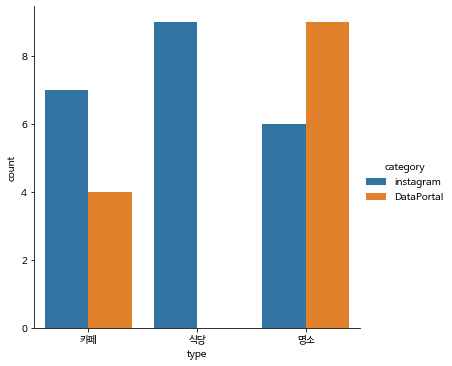

In [ ]:
sns.catplot(x="type", kind = 'count', hue = 'category', data = df);

* 인스타그램에서 가져온 데이터들 중 상위 약 20개 정도의 데이터로 확인 하였을 때 카페, 명소, 식당 모두 고르게 분포되어 있었음.  
* 데이터포털에서 가져온 강릉시 핫플레이스는 명소가 가장 많았고, 그 다음으로 카페, 식당은 하나도 없었음.  
* 정리해보면 카페와 식당은 인스타그램으로 확인하고, 명소는 강릉시 추천 핫플레이스 또는 인스타그램으로 확인하면 될 것임